In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import mean
from numpy import array
# from prettytable import PrettyTable
# from tqdm import tqdm_notebook

# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
# from keras.layers import Bidirectional
# from keras.layers import Flatten
# from keras.layers import TimeDistributed
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D

from sklearn.metrics import mean_squared_error

This article covers the main method used: https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/

In [19]:
# Read in the CSV
incidents = pd.read_csv("../incident_data/yearly_incident_data/all_incidents.csv", low_memory=False)
incidents = incidents.dropna()
incidents.head()

,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentDate,incidentTime
0,0056Xx Lyndale Av S,MP2010000051,5,CSCR,Crim Sex Cond-Rape,3.0,44.900291,-93.288239,Windom,2010/01/01,00:30
1,0001Xx 62 St W,MP2010000099,5,ROBPAG,Robbery Per Agg,4.0,44.890636,-93.280041,Windom,2010/01/01,01:05
2,0039Xx 5 Av S,MP2010000373,3,BURGD,Burglary Of Dwelling,6.0,44.931448,-93.268841,Bryant,2010/01/01,04:18
3,0013Xx Nicollet Av S,MP2010000305,1,ASLT2,Asslt W/Dngrs Weapon,5.0,44.970506,-93.277714,Loring Park,2010/01/01,03:00
4,0034Xx Oliver Av N,MP2010000229,4,BURGD,Burglary Of Dwelling,6.0,45.017746,-93.306988,Folwell,2010/01/01,02:23


In [20]:
# Reset the index to date, and split the date into fields for analysis
incidents.index = pd.DatetimeIndex(incidents.incidentDate)

incidents['month'] = incidents.index.month
incidents['year'] = incidents.index.year
incidents['dayOfWeek'] = incidents.index.dayofweek
incidents['dayOfMonth'] = incidents.index.day
incidents['dayOfYear'] = incidents.index.dayofyear
incidents['weekOfMonth'] = incidents.dayOfMonth.apply(lambda d: (d-1) // 7 +1)

dayOfYear = list(incidents.index.dayofyear)
weekOfYear = [math.ceil(i/7) for i in dayOfYear]
incidents['weekOfYear'] = weekOfYear

incidents = incidents.sort_index()

incidents.loc[(incidents['neighborhood'] == "Steven'S Square - Loring Heights"), 'neighborhood'] = 'Stevens Square - Loring Heights'

incidents.head()

,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentDate,incidentTime,month,year,dayOfWeek,dayOfMonth,dayOfYear,weekOfMonth,weekOfYear
incidentDate,,,,,,,,,,,,,,,,,,
2010-01-01,0056Xx Lyndale Av S,MP2010000051,5,CSCR,Crim Sex Cond-Rape,3.0,44.900291,-93.288239,Windom,2010/01/01,00:30,1,2010,4,1,1,1,1
2010-01-01,0021Xx Lake St E,MP2010001305,3,BURGB,Burglary Of Business,6.0,44.948372,-93.241320,Corcoran,2010/01/01,22:44,1,2010,4,1,1,1,1
2010-01-01,0021Xx Lake St E,MP2010001306,3,BURGB,Burglary Of Business,6.0,44.948372,-93.241320,Corcoran,2010/01/01,22:44,1,2010,4,1,1,1,1
2010-01-01,0021Xx Lake St E,MP2010001311,3,BURGB,Burglary Of Business,6.0,44.948372,-93.241320,Corcoran,2010/01/01,22:44,1,2010,4,1,1,1,1
2010-01-01,0018Xx 6 St Ne,MP2010002789,2,CSCR,Crim Sex Cond-Rape,3.0,45.006353,-93.258512,Holland,2010/01/01,03:30,1,2010,4,1,1,1,1


In [21]:
# Training on 2010-2017 data, then using 2019 for testing. Need to investigate 2018 data - seems like we lost a large number of records potentially during the data cleaning phase when we dropped NAs
incidents_train = incidents.loc['2010-01-01':'2019-12-31']
incidents_test = incidents.loc['2020-01-01':'2020-12-31']

# Setup Train and Test Data Sets for Monthly Predictions

In [ ]:
# Gather the unique neighborhoods into a list
neighborhood_list = list(incidents['neighborhood'].unique())
print(neighborhood_list)

In [ ]:
# Training data - count of crimes by neighborhood by month
train_n = []
for neighborhood in neighborhood_list:
    df = incidents_train[incidents_train['neighborhood'] == neighborhood]
    df_gr = df.groupby(['year', 'month']).count()
    train_n.append(list(df_gr['incidentDate'].values))

In [ ]:
# Testing data - count of crimes by neighborhood by month
test_n = []
for neighborhood in neighborhood_list:
    df = incidents_test[incidents_test['neighborhood'] == neighborhood]
    df_gr = df.groupby(['month']).count()
    test_n.append(list(df_gr['incidentDate'].values))

## Simple Moving Average

In [ ]:
# Prepare situation. Used window of 3 (3 months - quarter of a year)
window = 3
predTot = list()
testTot = list()
# Walk forward over time steps in test
for neighborhoodNum in range(len(train_n)):
    
    history = train_n[neighborhoodNum]
    test = test_n[neighborhoodNum]
    preds = []
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length - window, length)])
        obs = test[t]
        preds.append(yhat)
        history.append(obs)
    
    print('Neighborhood #: {}'.format(neighborhoodNum+1))
    print('Name: {}'.format(neighborhood_list[neighborhoodNum]))
    print('Actuals: {}'.format(test))
    print('Predictions: {}'.format(preds))
    
    # Plot the actual crimes for the test period in blue, the prediction based on the training set is in red
    plt.plot(test, label='Actual')
    plt.plot(preds, color='red', label='Predicted')
    plt.title(neighborhood_list[neighborhoodNum])
    plt.xlabel('Month')
    plt.ylabel('Count of crimes')
    plt.legend(loc='upper right')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

# Neighborhood weekly predictions

In [ ]:
# Training data - count of crimes by neighborhood by week
train_n = []
for neighborhood in neighborhood_list:
    df = incidents_train[incidents_train['neighborhood'] == neighborhood]
    df_gr = df.groupby(['year', 'weekOfYear']).count()
    train_n.append(list(df_gr['incidentDate'].values))

In [ ]:
# Testing data - count of crimes by neighborhood by week
test_n = []
for neighborhood in neighborhood_list:
    df = incidents_test[incidents_test['neighborhood'] == neighborhood]
    df_gr = df.groupby(['weekOfYear']).count()
    test_n.append(list(df_gr['incidentDate'].values))

In [ ]:
# Prepare situation. Used window of 4 (4 week rolling average)
window = 4
predTot = list()
testTot = list()
# Walk forward over time steps in test
for neighborhoodNum in range(len(train_n)):
    
    history = train_n[neighborhoodNum]
    test = test_n[neighborhoodNum]
    preds = []
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length - window, length)])
        obs = test[t]
        preds.append(yhat)
        history.append(obs)
    
    print('Neighborhood #: {}'.format(neighborhoodNum+1))
    print('Name: {}'.format(neighborhood_list[neighborhoodNum]))
    # print('Actuals: {}'.format(test))
    # print('Predictions: {}'.format(preds))
    
    # Plot the actual crimes for the test period in blue, the prediction based on the training set is in red
    plt.plot(test, label='Actual')
    plt.plot(preds, color='red', label='Predicted')
    plt.title(neighborhood_list[neighborhoodNum])
    plt.xlabel('Week No.')
    plt.ylabel('Count of crimes')
    plt.legend(loc='upper right')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

## Predictions by offense - weekly

In [37]:
# Get a list of offenses
offense_list = list(incidents['offense'].unique())
print(offense_list)

['CSCR', 'BURGB', 'THEFT', 'BURGD', 'ROBPER', 'TFMV', 'ASLT3', 'THFTSW', 'ROBPAG', 'AUTOTH', 'ROBBIZ', 'SHOPLF', 'DASLT2', 'ASLT2', 'DASTR', 'MURDR', 'ASLT4', 'TFPER', 'TBLDG', 'TMVP', 'ASLT1', 'DASLT3', 'ARSON', 'POCKET', 'ONLTHT', 'NOPAY', 'MVTHFT', 'COMPUT', 'DISARM', 'COINOP', 'DASLT1', 'BIKETF', 'SCRAP', 'JHOMIC', 'LOOT', 'THEFT   ', 'TFMV    ', 'BURGD   ', 'THFTSW  ', 'BIKETF  ', 'BURGB   ', 'CSCR    ', 'AUTOTH  ', 'DASLT3  ', 'SHOPLF  ', 'TBLDG   ', 'ROBPER  ', 'ASLT2   ', 'ROBPAG  ', 'DASTR   ', 'DASLT2  ', 'TFPER   ', 'ARSON   ', 'ASLT4   ', 'PETIT   ', 'ASLT3   ', 'TMVP    ', 'MVTHFT  ', 'COINOP  ', 'ROBBIZ  ', 'ASLT1   ', 'MURDR   ', 'ONLTHT  ', 'SCRAP   ', 'POCKET  ', 'DASLT1  ', 'COMPUT  ', 'LOOT    ', 'DISARM  ', 'NOPAY   ']


In [38]:
# Clean up offense field
offense_data = incidents['offense'].to_list()
# print(precinct_data)

offense_list = []

for offense in offense_data:
    offense_cln = offense.replace(' ', '')
    offense_list.append(offense_cln)

# print(offense_list)

# Insert corrected offense back into the df
incidents['offense'] = offense_list
incidents['offense'] = incidents['offense']
# incidents.head()

offense_list = list(incidents['offense'].unique())
print(offense_list)

['CSCR', 'BURGB', 'THEFT', 'BURGD', 'ROBPER', 'TFMV', 'ASLT3', 'THFTSW', 'ROBPAG', 'AUTOTH', 'ROBBIZ', 'SHOPLF', 'DASLT2', 'ASLT2', 'DASTR', 'MURDR', 'ASLT4', 'TFPER', 'TBLDG', 'TMVP', 'ASLT1', 'DASLT3', 'ARSON', 'POCKET', 'ONLTHT', 'NOPAY', 'MVTHFT', 'COMPUT', 'DISARM', 'COINOP', 'DASLT1', 'BIKETF', 'SCRAP', 'JHOMIC', 'LOOT', 'PETIT']


In [39]:
# Training data by offense by week
train_o = []
for offense in offense_list:
    df = incidents_train[incidents_train['offense'] == offense]
    df_gr = df.groupby(['year', 'weekOfYear']).count()
    train_o.append(list(df_gr['incidentDate'].values))

In [40]:
test_o = []
for offense in offense_list:
    df = incidents_test[incidents_test['offense'] == offense]
    df_gr = df.groupby(['weekOfYear']).count()
    test_o.append(list(df_gr['incidentDate'].values))

Offense #: 1
Offense: CSCR
Actuals: []
Predictions: []


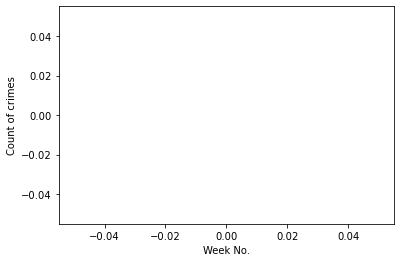

Offense #: 2
Offense: BURGB
Actuals: []
Predictions: []


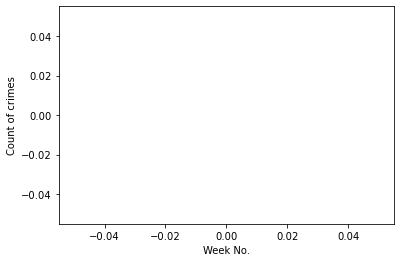

Offense #: 3
Offense: THEFT
Actuals: []
Predictions: []


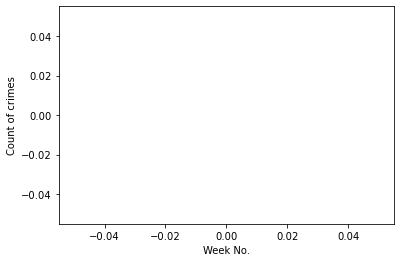

Offense #: 4
Offense: BURGD
Actuals: []
Predictions: []


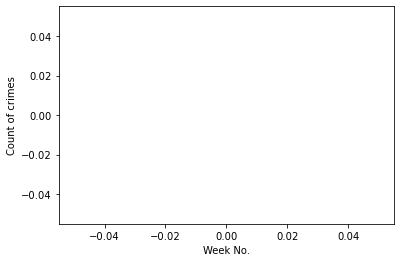

Offense #: 5
Offense: ROBPER
Actuals: []
Predictions: []


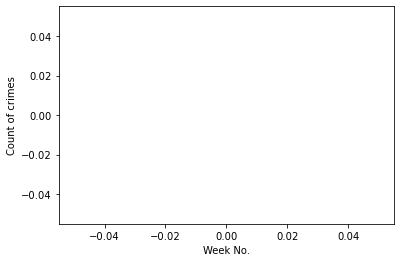

Offense #: 6
Offense: TFMV
Actuals: []
Predictions: []


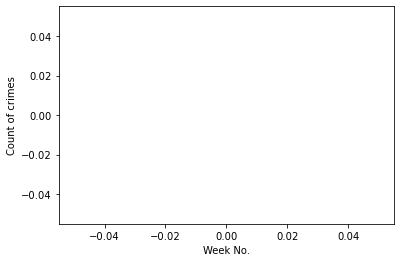

Offense #: 7
Offense: ASLT3
Actuals: []
Predictions: []


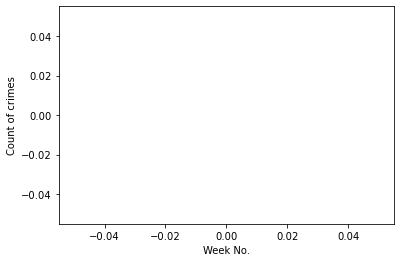

Offense #: 8
Offense: THFTSW
Actuals: []
Predictions: []


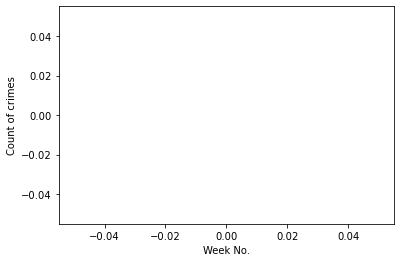

Offense #: 9
Offense: ROBPAG
Actuals: []
Predictions: []


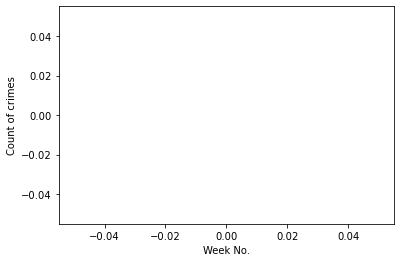

Offense #: 10
Offense: AUTOTH
Actuals: []
Predictions: []


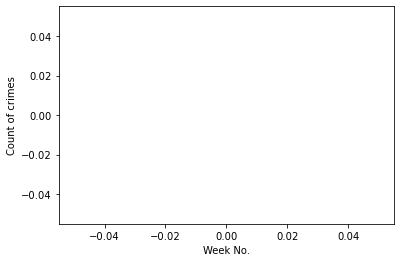

Offense #: 11
Offense: ROBBIZ
Actuals: []
Predictions: []


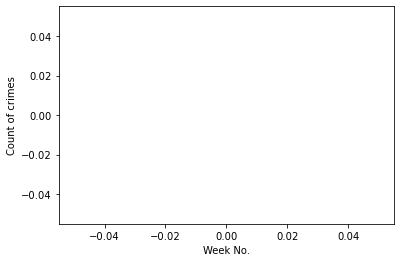

Offense #: 12
Offense: SHOPLF
Actuals: []
Predictions: []


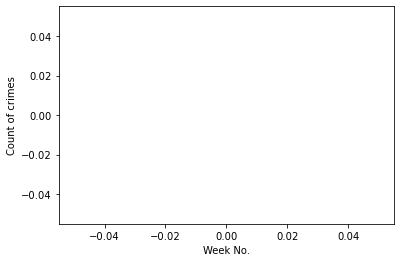

Offense #: 13
Offense: DASLT2
Actuals: []
Predictions: []


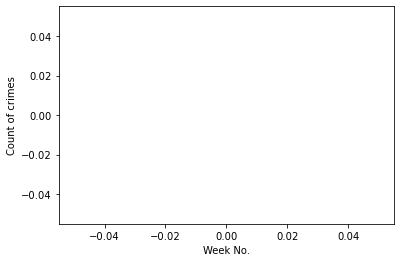

Offense #: 14
Offense: ASLT2
Actuals: []
Predictions: []


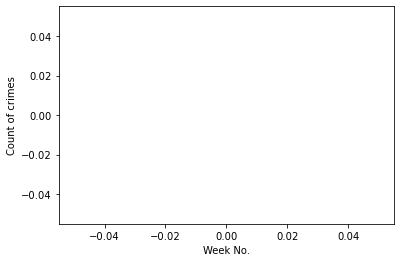

Offense #: 15
Offense: DASTR
Actuals: []
Predictions: []


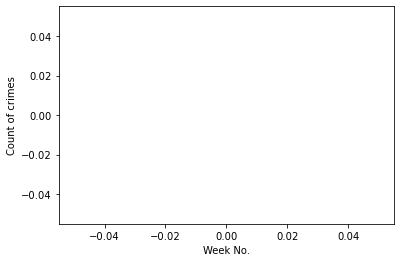

Offense #: 16
Offense: MURDR
Actuals: []
Predictions: []


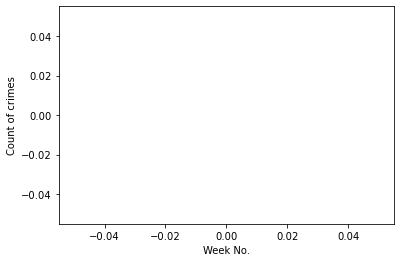

Offense #: 17
Offense: ASLT4
Actuals: []
Predictions: []


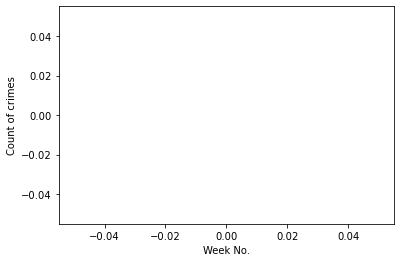

Offense #: 18
Offense: TFPER
Actuals: []
Predictions: []


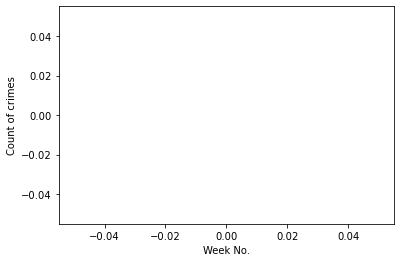

Offense #: 19
Offense: TBLDG
Actuals: []
Predictions: []


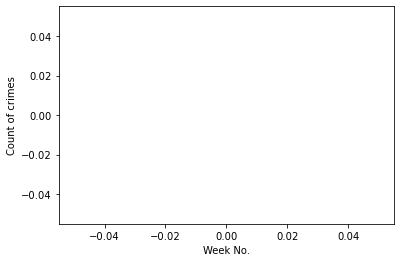

Offense #: 20
Offense: TMVP
Actuals: []
Predictions: []


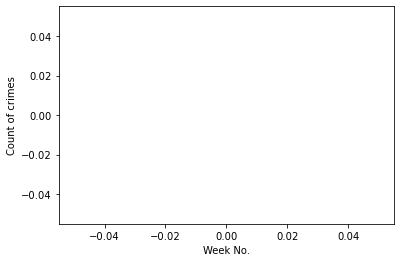

Offense #: 21
Offense: ASLT1
Actuals: []
Predictions: []


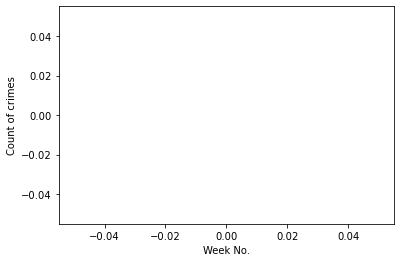

Offense #: 22
Offense: DASLT3
Actuals: []
Predictions: []


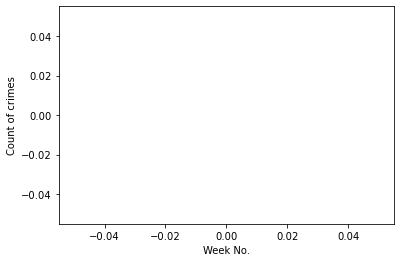

Offense #: 23
Offense: ARSON
Actuals: []
Predictions: []


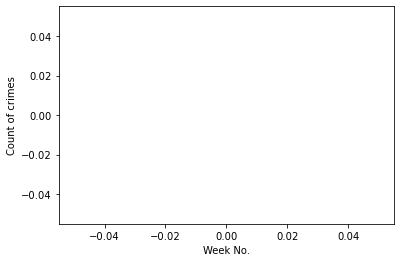

Offense #: 24
Offense: POCKET
Actuals: []
Predictions: []


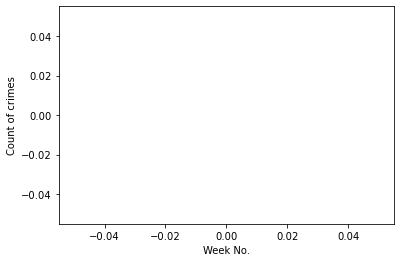

Offense #: 25
Offense: ONLTHT
Actuals: []
Predictions: []


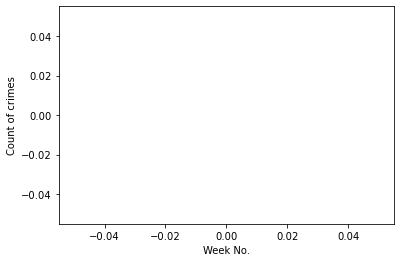

Offense #: 26
Offense: NOPAY
Actuals: []
Predictions: []


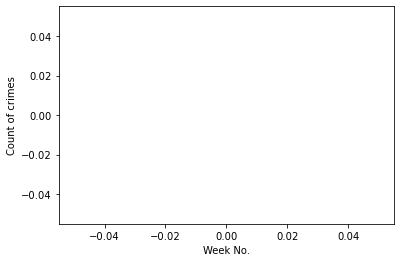

Offense #: 27
Offense: MVTHFT
Actuals: []
Predictions: []


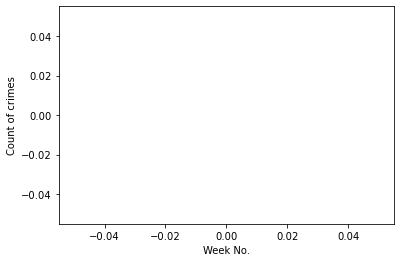

Offense #: 28
Offense: COMPUT
Actuals: []
Predictions: []


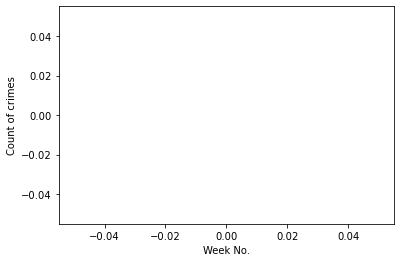

Offense #: 29
Offense: DISARM
Actuals: []
Predictions: []


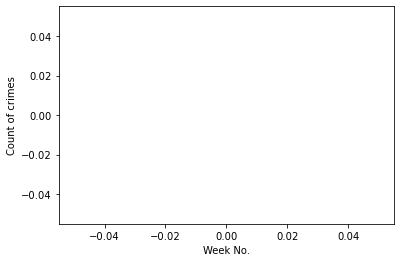

Offense #: 30
Offense: COINOP
Actuals: []
Predictions: []


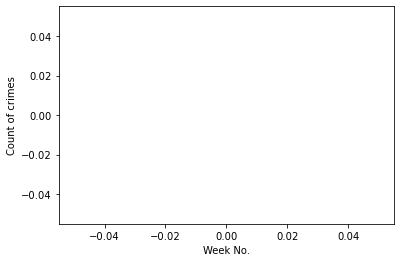

Offense #: 31
Offense: DASLT1
Actuals: []
Predictions: []


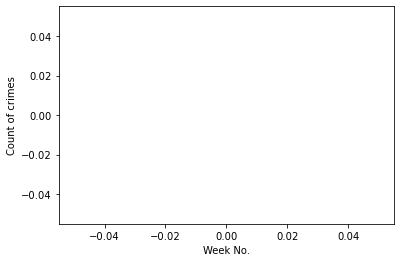

Offense #: 32
Offense: BIKETF
Actuals: []
Predictions: []


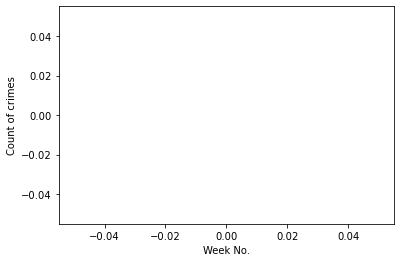

Offense #: 33
Offense: SCRAP
Actuals: []
Predictions: []


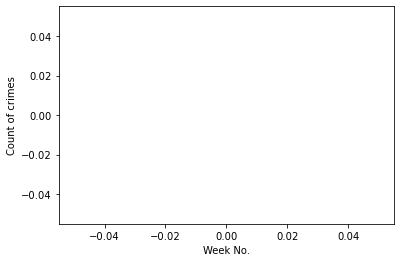

Offense #: 34
Offense: JHOMIC
Actuals: []
Predictions: []


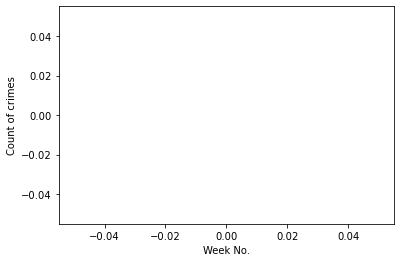

Offense #: 35
Offense: LOOT
Actuals: []
Predictions: []


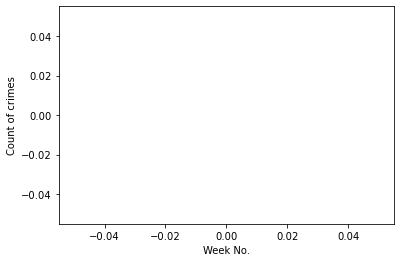

Offense #: 36
Offense: PETIT
Actuals: []
Predictions: []


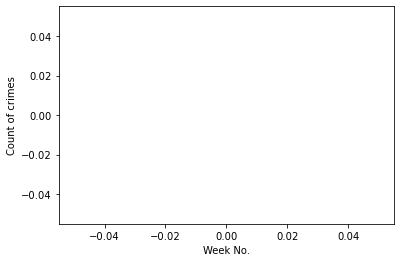

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [41]:
# Prepare situation
window = 4
predTot = list()
testTot = list()
# Walk forward over time steps in test
for offenseNum in range(len(train_o)):
    
    history = train_o[offenseNum]
    test = test_o[offenseNum]
    preds = []
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length - window, length)])
        obs = test[t]
        preds.append(yhat)
        history.append(obs)
    
    print('Offense #: {}'.format(offenseNum+1))
    print('Offense: {}'.format(offense_list[offenseNum]))
    print('Actuals: {}'.format(test))
    print('Predictions: {}'.format(preds))

    # plot
    plt.plot(test)
    plt.plot(preds, color='red')
    plt.xlabel('Week No.')
    plt.ylabel('Count of crimes')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

## Predictions by ucr code weekly

In [33]:
# Get the list of ucr codes
ucr_list = list(incidents['ucrCode'].unique())
print(ucr_list)

[3.0, 6.0, 7.0, 4.0, 5.0, 8.0, 1.0, 10.0]


In [34]:
# Training data by ucr code by week
train_u = []
for ucr in ucr_list:
    df = incidents_train[incidents_train['ucrCode'] == ucr]
    df_gr = df.groupby(['year', 'weekOfYear']).count()
    train_u.append(list(df_gr['incidentDate'].values))

In [35]:
# Testing data by ucr code by week
test_u = []
for ucr in ucr_list:
    df = incidents_test[incidents_test['ucrCode'] == ucr]
    df_gr = df.groupby(['weekOfYear']).count()
    test_u.append(list(df_gr['incidentDate'].values))

Offense #: 1
Offense: 3.0
Actuals: [10, 6, 8, 4, 9, 13, 7, 4, 4, 10, 5, 6, 5, 6, 4, 6, 2, 5, 1, 5, 5, 3, 3, 3, 7, 7, 7, 4, 4, 2, 7, 4, 10, 3, 5, 3, 4, 5, 3, 6, 5, 5, 5, 5, 7, 2, 3, 4, 2, 5, 4, 5]
Predictions: [5.25, 7.5, 7.5, 7.25, 7.0, 6.75, 8.5, 8.25, 8.25, 7.0, 6.25, 5.75, 6.25, 6.5, 5.5, 5.25, 5.25, 4.5, 4.25, 3.5, 3.25, 4.0, 3.5, 4.0, 3.5, 4.0, 5.0, 6.0, 6.25, 5.5, 4.25, 4.25, 4.25, 5.75, 6.0, 5.5, 5.25, 3.75, 4.25, 3.75, 4.5, 4.75, 4.75, 5.25, 5.0, 5.5, 4.75, 4.25, 4.0, 2.75, 3.5, 3.75]


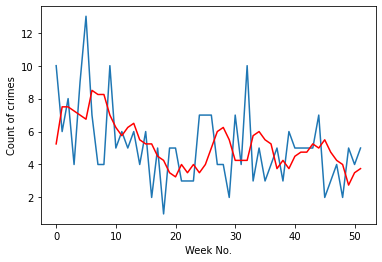

Offense #: 2
Offense: 6.0
Actuals: [50, 38, 47, 42, 29, 31, 38, 30, 36, 50, 41, 54, 57, 63, 86, 77, 77, 70, 58, 72, 96, 406, 72, 63, 69, 65, 87, 62, 92, 111, 58, 83, 73, 82, 141, 80, 73, 84, 82, 82, 82, 66, 85, 79, 82, 86, 74, 74, 52, 67, 60, 45]
Predictions: [64.0, 59.25, 52.25, 49.0, 44.25, 39.0, 37.25, 35.0, 32.0, 33.75, 38.5, 39.25, 45.25, 50.5, 53.75, 65.0, 70.75, 75.75, 77.5, 70.5, 69.25, 74.0, 158.0, 161.5, 159.25, 152.5, 67.25, 71.0, 70.75, 76.5, 88.0, 80.75, 86.0, 81.25, 74.0, 94.75, 94.0, 94.0, 94.5, 79.75, 80.25, 82.5, 78.0, 78.75, 78.0, 78.0, 83.0, 80.25, 79.0, 71.5, 66.75, 63.25]


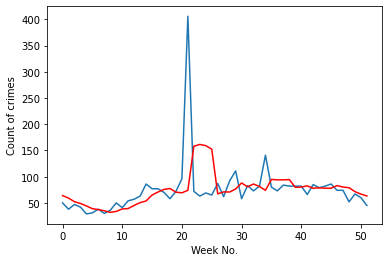

Offense #: 3
Offense: 7.0
Actuals: [215, 183, 190, 208, 210, 181, 191, 199, 217, 234, 195, 174, 160, 170, 179, 175, 187, 182, 166, 189, 160, 96, 116, 162, 174, 182, 184, 171, 196, 236, 247, 236, 225, 241, 253, 236, 222, 206, 243, 247, 218, 210, 234, 211, 168, 171, 197, 144, 181, 166, 171, 96]
Predictions: [201.5, 199.5, 199.0, 188.5, 199.0, 197.75, 197.25, 197.5, 195.25, 197.0, 210.25, 211.25, 205.0, 190.75, 174.75, 170.75, 171.0, 177.75, 180.75, 177.5, 181.0, 174.25, 152.75, 140.25, 133.5, 137.0, 158.5, 175.5, 177.75, 183.25, 196.75, 212.5, 228.75, 236.0, 237.25, 238.75, 238.75, 238.0, 229.25, 226.75, 229.5, 228.5, 229.5, 227.25, 218.25, 205.75, 196.0, 186.75, 170.0, 173.25, 172.0, 165.5]


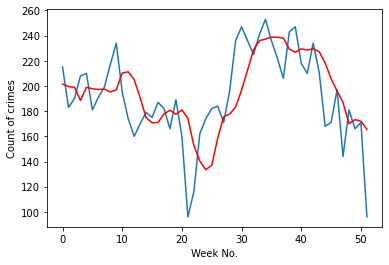

Offense #: 4
Offense: 4.0
Actuals: [20, 19, 16, 16, 14, 12, 15, 13, 16, 10, 27, 15, 14, 11, 12, 12, 10, 17, 11, 6, 14, 22, 13, 16, 24, 22, 29, 27, 51, 41, 29, 16, 17, 37, 47, 43, 31, 21, 20, 36, 25, 29, 17, 26, 23, 11, 11, 24, 18, 12, 15, 6]
Predictions: [15.0, 17.25, 18.75, 17.25, 17.75, 16.25, 14.5, 14.25, 13.5, 14.0, 13.5, 16.5, 17.0, 16.5, 16.75, 13.0, 12.25, 11.25, 12.75, 12.5, 11.0, 12.0, 13.25, 13.75, 16.25, 18.75, 18.75, 22.75, 25.5, 32.25, 37.0, 37.0, 34.25, 25.75, 24.75, 29.25, 36.0, 39.5, 35.5, 28.75, 27.0, 25.5, 27.5, 26.75, 24.25, 23.75, 19.25, 17.75, 17.25, 16.0, 16.25, 17.25]


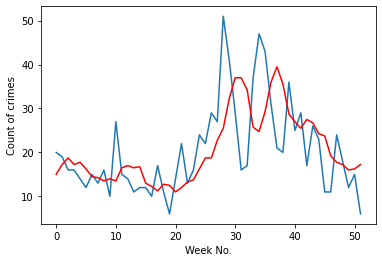

Offense #: 5
Offense: 5.0
Actuals: [37, 19, 30, 40, 25, 31, 23, 22, 39, 29, 31, 22, 28, 18, 30, 28, 26, 33, 19, 35, 39, 60, 37, 44, 48, 51, 51, 54, 45, 46, 41, 43, 43, 40, 31, 31, 36, 37, 35, 29, 42, 29, 35, 50, 44, 31, 36, 33, 35, 26, 20, 28]
Predictions: [27.25, 31.0, 30.0, 30.5, 31.5, 28.5, 31.5, 29.75, 25.25, 28.75, 28.25, 30.25, 30.25, 27.5, 24.75, 24.5, 26.0, 25.5, 29.25, 26.5, 28.25, 31.5, 38.25, 42.75, 45.0, 47.25, 45.0, 48.5, 51.0, 50.25, 49.0, 46.5, 43.75, 43.25, 41.75, 39.25, 36.25, 34.5, 33.75, 34.75, 34.25, 35.75, 33.75, 33.75, 39.0, 39.5, 40.0, 40.25, 36.0, 33.75, 32.5, 28.5]


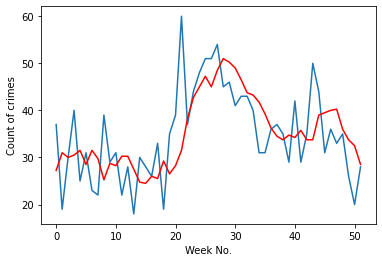

Offense #: 6
Offense: 8.0
Actuals: [53, 64, 128, 80, 64, 87, 99, 71, 54, 66, 63, 62, 54, 43, 61, 44, 47, 49, 48, 46, 57, 53, 45, 66, 64, 65, 63, 73, 76, 88, 75, 72, 69, 68, 71, 70, 60, 78, 49, 60, 52, 55, 78, 77, 53, 81, 57, 56, 61, 62, 77, 50]
Predictions: [56.25, 55.5, 57.0, 75.0, 81.25, 84.0, 89.75, 82.5, 80.25, 77.75, 72.5, 63.5, 61.25, 61.25, 55.5, 55.0, 50.5, 48.75, 50.25, 47.0, 47.5, 50.0, 51.0, 50.25, 55.25, 57.0, 60.0, 64.5, 66.25, 69.25, 75.0, 78.0, 77.75, 76.0, 71.0, 70.0, 69.5, 67.25, 69.75, 64.25, 61.75, 59.75, 54.0, 61.25, 65.5, 65.75, 72.25, 67.0, 61.75, 63.75, 59.0, 64.0]


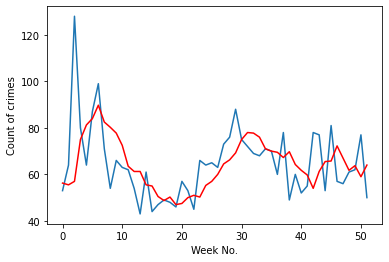

Offense #: 7
Offense: 1.0
Actuals: [1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 3, 2, 1, 4, 4, 3, 2, 2, 3, 2, 4, 1, 2, 2, 2, 1, 1, 2, 1, 1, 3, 2, 1, 1]
Predictions: [1.25, 1.25, 1.25, 1.25, 1.0, 1.25, 1.25, 1.25, 1.5, 1.25, 1.25, 1.25, 1.5, 1.75, 1.75, 2.5, 2.75, 3.0, 3.25, 2.75, 2.5, 2.25, 2.75, 2.5, 2.25, 2.25, 1.75, 1.75, 1.5, 1.5, 1.25, 1.25, 1.75, 1.75, 1.75]


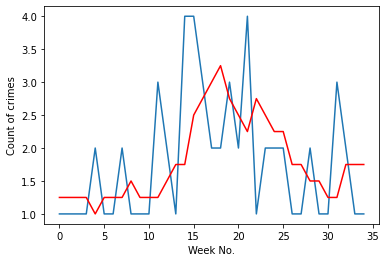

Offense #: 8
Offense: 10.0
Actuals: [1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 4, 1, 10, 3, 1, 3, 4, 1, 3, 7, 5, 2, 1, 1, 1, 6, 4, 3, 2, 4, 5, 3, 1, 1, 1, 4, 1, 2]
Predictions: [1.5, 1.25, 1.25, 1.5, 1.5, 1.75, 1.75, 1.5, 1.25, 1.0, 1.25, 1.25, 1.5, 2.25, 2.0, 4.25, 4.5, 3.75, 4.25, 2.75, 2.25, 2.75, 3.75, 4.0, 4.25, 3.75, 2.25, 1.25, 2.25, 3.0, 3.5, 3.75, 3.25, 3.5, 3.5, 3.25, 2.5, 1.5, 1.75, 1.75]


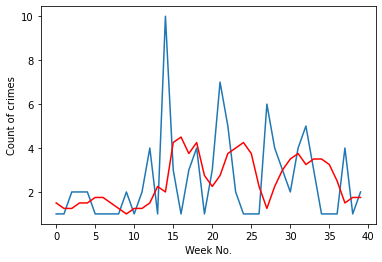

Test RMSE: 23.694


In [36]:
# Prepare situation
window = 4
predTot = list()
testTot = list()
# Walk forward over time steps in test
for ucrCode in range(len(train_u)):
    
    history = train_u[ucrCode]
    test = test_u[ucrCode]
    preds = []
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length - window, length)])
        obs = test[t]
        preds.append(yhat)
        history.append(obs)
    
    print('Offense #: {}'.format(ucrCode+1))
    print('Offense: {}'.format(ucr_list[ucrCode]))
    print('Actuals: {}'.format(test))
    print('Predictions: {}'.format(preds))

    # plot
    plt.plot(test)
    plt.plot(preds, color='red')
    plt.xlabel('Week No.')
    plt.ylabel('Count of crimes')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

## Total crime count predictions by week for the entire city

In [18]:
incidents_train

,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentDate,incidentTime,month,year,dayOfWeek,dayOfMonth,dayOfYear,weekOfMonth,weekOfYear
incidentDate,,,,,,,,,,,,,,,,,,
2010-01-01,0056Xx Lyndale Av S,MP2010000051,5,CSCR,Crim Sex Cond-Rape,3.0,44.900291,-93.288239,Windom,2010/01/01,00:30,1,2010,4,1,1,1,1
2010-01-01,0021Xx Lake St E,MP2010001305,3,BURGB,Burglary Of Business,6.0,44.948372,-93.241320,Corcoran,2010/01/01,22:44,1,2010,4,1,1,1,1
2010-01-01,0021Xx Lake St E,MP2010001306,3,BURGB,Burglary Of Business,6.0,44.948372,-93.241320,Corcoran,2010/01/01,22:44,1,2010,4,1,1,1,1
2010-01-01,0021Xx Lake St E,MP2010001311,3,BURGB,Burglary Of Business,6.0,44.948372,-93.241320,Corcoran,2010/01/01,22:44,1,2010,4,1,1,1,1
2010-01-01,0018Xx 6 St Ne,MP2010002789,2,CSCR,Crim Sex Cond-Rape,3.0,45.006353,-93.258512,Holland,2010/01/01,03:30,1,2010,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30,0011Xx 25Th Ave N,MP2019380239,4,TFMV,Theft From Motr Vehc,7.0,45.004819,-93.294872,Jordan,2019/12/30,19:04,12,2019,0,30,364,5,52
2019-12-30,0038Xx Sheridan Ave N,MP2019380235,4,TFMV,Theft From Motr Vehc,7.0,45.024999,-93.312181,Victory,2019/12/30,00:04,12,2019,0,30,364,5,52
2019-12-30,0029Xx 32Nd Ave S,MP2019380314,3,BURGD,Burglary Of Dwelling,6.0,44.949273,-93.225682,Longfellow,2019/12/30,15:00,12,2019,0,30,364,5,52


In [28]:
# Try dropping week 53 results - see how that impacts the model. Answer - improves by 14pts
incidents_train = incidents_train.loc[incidents_train['weekOfYear']!=53]
incidents_test = incidents_test.loc[incidents_test['weekOfYear']!=53]
# incidents_train

In [29]:
# Set up training data
train_df = incidents_train.groupby(['year', 'weekOfYear']).count()
train_c = train_df['caseNumber'].to_list()
# print(train_c)

# Set up testing data
test_df = incidents_test.groupby(['weekOfYear']).count()
test_c = test_df['caseNumber'].to_list()
# print(test_c)

Actuals: [387, 330, 420, 393, 353, 358, 376, 341, 367, 400, 363, 335, 320, 312, 372, 343, 351, 360, 303, 355, 372, 653, 291, 356, 393, 396, 426, 397, 473, 529, 461, 455, 441, 474, 558, 467, 427, 434, 436, 466, 431, 398, 456, 450, 378, 384, 382, 341, 350, 340, 348, 231]
Predictions: [317.25, 326.5, 324.0, 342.0, 382.5, 374.0, 381.0, 370.0, 357.0, 360.5, 371.0, 367.75, 366.25, 354.5, 332.5, 334.75, 336.75, 344.5, 356.5, 339.25, 342.25, 347.5, 420.75, 417.75, 418.0, 423.25, 359.0, 392.75, 403.0, 423.0, 456.25, 465.0, 479.5, 471.5, 457.75, 482.0, 485.0, 481.5, 471.5, 441.0, 440.75, 441.75, 432.75, 437.75, 433.75, 420.5, 417.0, 398.5, 371.25, 364.25, 353.25, 344.75]


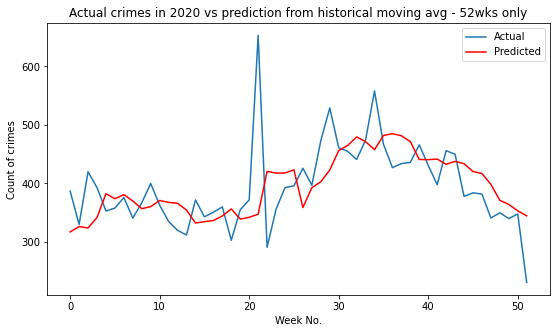

Test RMSE: 63.934


In [32]:
window = 4
predTot = list()
testTot = list()

history = train_c
test = test_c
preds = []

for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length - window, length)])
    obs = test[t]
    preds.append(yhat)
    history.append(obs)

print('Actuals: {}'.format(test))
print('Predictions: {}'.format(preds))

plt.figure(figsize=(9,5))
plt.plot(test, label='Actual')
plt.plot(preds, color='red', label='Predicted')
plt.title('Actual crimes in 2020 vs prediction from historical moving avg - 52wks only')
plt.xlabel('Week No.')
plt.ylabel('Count of crimes')
plt.legend(loc='upper right')
plt.savefig('images/weekly52_pred.png')
plt.show()

testTot = testTot + test
predTot = predTot + preds

error = mean_squared_error(predTot, testTot) ** .5

print('Test RMSE: %.3f' % error)


In [15]:
week_avg = sum(preds)/len(preds)
week_avg

398.1298076923077

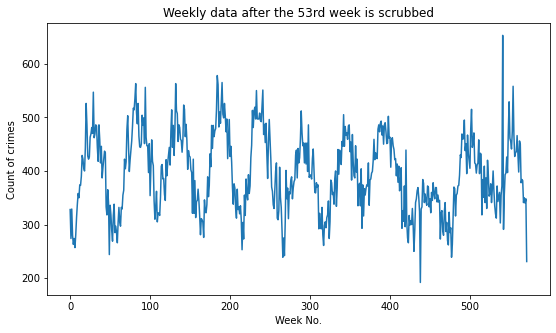

In [31]:
plt.figure(figsize=(9,5))
# plt.plot(test, label='Actual')
plt.plot(history, label='History')
# plt.plot(preds, color='red', label='Predicted')
plt.title('Weekly data after the 53rd week is scrubbed')
plt.xlabel('Week No.')
plt.ylabel('Count of crimes')
# plt.legend(loc='upper right')
plt.savefig('images/weekly52_history.png')
plt.show()